# EE603 Coding Assignment
- Use python3
- Submit your "rendered" ipynb, i.e., with outputs of codes (plots and printed values) visible below
- Do not change the return variables, as the evaluation is done by test cases based on the variables specified. Only add your code at "### WRITE YOUR CODE HERE"
- Use only numpy and librosa library for computing and signal processing, no other package allowed
- If you are using your mobile phone, you can use colab.research.google.com for coding
- Do not define multiple functions using same name. We will be using eval.py to auto evaluate your codes. Please check with sample test cases before submitting. We will share the evaluation test cases with you after the submission deadline.
- While submitting this file, change file name from 'YourRollNo.ipynb' to your actual roll no (Eg. 18204279.ipynb)

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [62]:
import glob
def readDir(dirname, Fs = 22050):
    
    '''
    Each audio clip should be upto 10s long; split larger audio files into many clips (non-overlapping) 

    Use load_audio(file) 
    
    Inputs: 
        dirname: (str) directory name
        Fs: (int) sampling rate
    Output: 
        x: np arrays of shape (Nclips, Nsamples) Nsamples correspond to 10s length. Use zero-padding for shorter clips.
    '''  


    ### WRITE YOUR CODE HERE - 5 MARKS
    required_duration = 10
    x = np.zeros(required_duration*Fs)
    
    for path in glob.iglob(f'{dirname}/*.wav'):
        audio = load_audio(path, Fs)
        num_per_clip = Fs*required_duration   # Number of point samples for 10s audio clip
        N = (int)(audio.shape[0]/num_per_clip)
        for i in range(0, N):
            x = np.vstack((x, audio[i*num_per_clip : (i+1)*num_per_clip]))
         
        # Last audio sample must be zero padded
        if(audio.shape[0]%num_per_clip != 0):
            seq = audio[N*num_per_clip:]
            seq = librosa.util.fix_length(seq, required_duration*Fs)
            x = np.vstack((x, seq))

    # We need to skip the initial zero array which was added for convenience
    x = x[1:, :]           # Nclips x Nsamples
    
    return x 

In [63]:
def load_audio(filename, Fs = 22050):
    '''
    Inputs: 
        filename: (str) filename
        Fs: (int) sampling rate
    Output: 
        x: 1D np array 
    '''
    

    ### WRITE YOUR CODE HERE - 2 MARKS
    x, sr = librosa.load(filename, sr=Fs)
    
    return x

In [64]:
def splitData(X, t, testFraction=0.2, randomize = False):
    """
    Split the data randomly into training and test sets
    Use numpy functions only
    Inputs:
        X: (np array of len Nclips) input feature vectors
        t: (np array of len Nclips) targets; one hot vectors
        testFraction: (float) Nclips_test = testFraction * Nclips
    Outputs:
        X_train: training set
        X_test: test set
        t_train: training labels
        t_test: test labels
    """


    ### WRITE YOUR CODE HERE - 5 MARKS
    np.random.seed(0)
    test_size = (int)(testFraction * X.shape[0])
    indices = np.random.permutation(X.shape[0])
    training_index, test_index = indices[:X.shape[0] - test_size], indices[X.shape[0] - test_size:]
    X_train, t_train = X[training_index, :], t[training_index, :]
    X_test, t_test = X[test_index, :], t[test_index, :]

    return X_train, t_train, X_test, t_test

In [65]:
def audio2mfcc(x, n_mfcc = 13, Fs = 22050):
    
    '''
    Compute Mel-frequency cepstral coefficients (MFCCs)
    Inputs:
        x: np array of shape (Nclips,)
        Fs: (int) sampling rate
        n_mfcc: (int) number of MFCC features
    Output:
        X: (np array) MFCC sequence
    '''

    ### WRITE YOUR CODE HERE - 3 MARKS
    X = []
    for i in range(len(x)):
        mfccs = librosa.feature.mfcc(y=x[i], sr=Fs, n_mfcc=n_mfcc, hop_length=512)
        X.append(mfccs)
            
#     X = np.concatenate(X)
    X = np.stack(X, axis=0) # 3D array => Nsample 2D arrays of MFCCs
#     print("mfcc feat : ", X.shape)

    return X                # (Nclips, N_mfcc, N_frames)

In [66]:
class Classifier: 
    '''
    Create a linear classifier to classify each frame
    '''
    def __init__(self):
        self.W = np.random.rand(21).reshape((21,1)) # define model parameters here
    
    def sigmoid(self, h):
        return 1/(1 + np.exp(-h))
    
    def loss_function(self, X, y): 
        # X : N x D
        # y : N x 1
        z = np.dot(X, self.W)
        pred_1 = y * np.log(self.sigmoid(z))
        pred_0 = (1 - y) * np.log(1 - self.sigmoid(z))
        return -np.sum(pred_1 + pred_0) / len(X)
        
    def train(self,x_train, y_train):
        '''
        Train the linear classifier
        Inputs:
            x_train: training set
            y_train: training labels
        Output:
            None
        '''

        ### WRITE YOUR CODE HERE - 0 MARKS
        X_speech = []
        X_music = []
        y = []
        # Segregate music and speech examples
        # each 10s sample is converted into a 2d array of size (13, 431) (MFCC)
        
        y_music = []
        y_speech = []
        for i in range(len(x_train)):
            if y_train[i][0]==1:
                y_music = y_music + [1]*x_train[i].shape[1]
                if len(X_music) == 0:
                    X_music = x_train[i]     # Nmfcc x 431
                else:
                    X_music = np.concatenate((X_music, x_train[i]), axis=1)
            else:
                y_speech = y_speech + [0]*x_train[i].shape[1]
                if len(X_speech) == 0:
                    X_speech = x_train[i]
                else:
                    X_speech = np.concatenate((X_speech, x_train[i]), axis=1)
        
        X_temp = np.concatenate((X_music, X_speech), axis=1) # Nmfcc x total no. of frames
        X_temp = (X_temp - np.mean(X_temp, axis=1,keepdims=True ))/np.std(X_temp, axis=1, keepdims=True) # standardize
        y = y_music + y_speech
        
        '''Logistic Regression Training'''
        t = np.array(y)
        t = t.reshape(t.shape[0], 1)
#         print(t.shape)
#         print(X_temp.shape)

        '''Add row of 1 in order to incorporate bias term'''
        one_row = np.ones((1,X_temp.shape[1]))
        X_temp = np.vstack((one_row, X_temp))
        X = X_temp.T                         # N x D
#         print(X.shape)
        
        '''Random weights initialization'''
        self.W = np.random.rand((X.shape[1])).reshape((X.shape[1],1))
        
        loss = []
        lr = 0.1
        N = X.shape[0]
        for i in range(300):
            y_pred = self.sigmoid(np.dot(X, self.W))
            grad = np.dot(X.T, y_pred - t)/N
            self.W -= lr * grad
            l = self.loss_function(X,t)
            loss.append(l)
            if (i+1)%50 == 0:
                print("Epoch %d : %f"% (i+1, l))
 
        plt.plot(loss)
#         print(self.W)
        return True
    
    def save_model(self, save_path):
        '''
        Save the trained model on local disk
        Input:
            save_path: location at which model is to be saved
        Output:
            None
        '''
        
        ### WRITE YOUR CODE HERE - 0 MARKS
#         file = open(save_path, "w+")
#         print(self.W.shape[0])
#         for i in range(self.W.shape[0]):
#             file.write(str(self.W[i][0]))
#             file.write("\n")    
#         file.close()
        np.save(save_path, self.W)
        return True
    
    def load_model(self, load_path):
        '''
        Save the trained model on local disk
        Input:
            load_path: location from which model is to be loaded
        Output:
            None
        '''
        
        ### WRITE YOUR CODE HERE - 0 MARKS
#         file = open(load_path, "r")
#         lines = file.readlines()
#         self.W = np.zeros((len(lines), 1))
#         for i in range(len(lines)):
#             self.W[i][0] = float(lines[i])
#         print(self.W)
        self.W = np.load(load_path)
        return None


    
    def predict_framewise(self,x_test):
        '''
        Framewise classification (speech or music)
        Input:
            x_test: test set
        Output:
            y_pred_framewise = framewise prediction
        '''
        

        ### WRITE YOUR CODE HERE - 5 MARKS
        '''Perform Normalization'''
        '''x_test shape : Nclips x Nmfcc x frame_per_clip'''
        x = x_test[0] 
        for i in range(1, len(x_test)):
            x = np.concatenate((x, x_test[i]), axis=1)
        
        x = (x - np.mean(x, axis=1, keepdims=True))/np.std(x, axis=1, keepdims=True) # Nmfcc x total_frames
        
        frames_per_sample = x_test[0].shape[1]
        
        '''Get original 3 shape back'''
        x_t = []
        for i in range(len(x_test)):
            x_t.append(x[:, frames_per_sample*i:frames_per_sample*(i+1)])
        
        x_t = np.stack(x_t, axis=0)
        x_test = x_t
        
        '''Start framewise prediction'''
        y_pred_framewise = []
        one_row = np.ones((1, x_test[0].shape[1]))
        x_t = []
        for i in range(len(x_test)):
            a = np.vstack((one_row, x_test[i]))
            x_t.append(np.vstack(a))
        
        x_t = np.stack(x_t, axis=0)
        
        for i in range(len(x_t)):
            # using W.T . X instead of X . W : Just makes a difference in shape for convenience
            pred = np.dot(self.W.T, x_t[i])
            pred = self.sigmoid(pred)
            pred = np.vstack((pred, pred)) # In order to match dimensions
            y_pred_framewise.append(pred)
        
        y_pred_framewise = np.stack(y_pred_framewise, axis=0)
#         print("y_pred_framewise : ", y_pred_framewise.shape)

        return y_pred_framewise 
    
    def predict_aggregate(self,y_pred_framewise):
        '''
        Aggregate frames to give a single class label (music or speech) to the entire audio file
        Input:
            y_pred_framewise = framewise prediction
        Output:
            y_hat = frame aggregate (one-hot vectors)
        '''

        ### WRITE YOUR CODE HERE - 5 MARKS
        y_hat = []
#         print('pred', y_pred_framewise.shape)
        for i in range(y_pred_framewise.shape[0]):
            frames_pred = y_pred_framewise[i][0].reshape((1,y_pred_framewise.shape[2]))
            result = np.sum(frames_pred > 0.5 , axis = 1)
#             print(result)
            # Majority voting
            if(result > (int)(y_pred_framewise.shape[2]/2)):
                y_hat.append([1,0]) # Music
            else:
                y_hat.append([0,1]) # Speech
        y_hat = np.stack(y_hat, axis=0)


        return y_hat

In [67]:
def computeCM(y, y_hat):
    '''
    Compute confusion matrix to evaluate your model
    Inputs:
        y = labels 
        y_hat = predicted output
    Output:
        confusion matrix: confusion matrix
    '''

    ### WRITE YOUR CODE HERE - 5 MARKS
    #                True  
    #           Speech |  Music
    #          _________________
    #    Speech|       |       |
    # Pred     -----------------
    #    Music |       |       |
    #          -----------------
    confusion_matrix = np.zeros((2,2))
    for i in range(y.shape[0]):
        r = (int)(y_hat[i][0])
        c = (int)(y[i][0])
        confusion_matrix[r][c] += 1


    return confusion_matrix 

Epoch 50 : 0.568942
Epoch 100 : 0.532842
Epoch 150 : 0.528627
Epoch 200 : 0.527699
Epoch 250 : 0.527437
Epoch 300 : 0.527355
[[31.  8.]
 [10. 27.]]


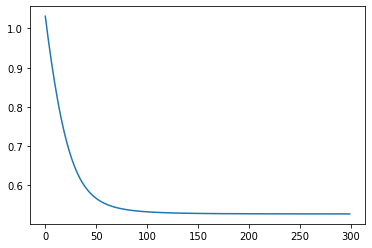

In [74]:
if __name__=="__main__":
    
    # My parameters
    Fs= 22050
    n_mfcc = 13
    
    '''NOTE : The model has been trained on the GZTAN music_speech dataset 
        http://marsyas.info/downloads/datasets.html
    '''
    # Read audio
    x_music = readDir('music_speech/music_wav', Fs)    #change it as per your directory
    x_speech = readDir('music_speech/speech_wav', Fs)  #change it as per your directory
    X = np.concatenate((x_music, x_speech))
    
    # Create labels
    y_music = np.array([[1,0]]*len(x_music))
    y_speech = np.array([[0,1]]*len(x_speech))
    Y = np.concatenate((y_music, y_speech))
    
    
    X_train, y_train, X_test, y_test = splitData(X, Y)
    
    # TRAINING 
    x_train = audio2mfcc(X_train, n_mfcc, Fs)    # x_train: (Nclips, N_mfcc, N_frames)
    model = Classifier() 
    model.train(x_train, y_train)        # y_train: (Nclips, 2) -repeat it N_frames times inside the train
    
    # TESTING 
    x_test = audio2mfcc(X_test, n_mfcc, Fs) 
    y_pred = model.predict_framewise(x_test)   # y_predict: (Nclips, 2, N_frames)
    y_hat = model.predict_aggregate(y_pred)    # y_hat: (Nclips, 2)

   # EVALUATION METRICS 
    confusion_matrix = computeCM(y_test, y_hat) 
    print(confusion_matrix) 

In [69]:
# model.save_model("weights.npy")

True

In [70]:
# M = Classifier()
# M.load_model("weights.npy")
# print(M.W)

[[ 0.05167005]
 [ 1.15008408]
 [ 0.9413482 ]
 [ 0.55262241]
 [ 0.27489016]
 [-0.05209373]
 [ 0.29904284]
 [ 0.43035029]
 [-0.23228537]
 [ 0.35785071]
 [-0.12981565]
 [-0.13138317]
 [-0.11461311]
 [ 0.19534376]]


In [71]:
# y_pred = M.predict_framewise(x_test)   # y_predict: (Nclips, 2, N_frames)
# y_hat = M.predict_aggregate(y_pred)    # y_hat: (Nclips, 2)

# # # EVALUATION METRICS 
# confusion_matrix = computeCM(y_test, y_hat) 
# print(confusion_matrix) 

[[31.  8.]
 [10. 27.]]
